<a href="https://colab.research.google.com/github/dickymrz/machine_learning_regression_time_series/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [79]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_customer = pd.read_csv("drive/My Drive/Colab Notebooks/VIX Kalbe Data Scientist/Challenge - Model Prediktif/dataset/customer.csv", delimiter = ';')
df_product = pd.read_csv("drive/My Drive/Colab Notebooks/VIX Kalbe Data Scientist/Challenge - Model Prediktif/dataset/product.csv", delimiter = ';')
df_store = pd.read_csv("drive/My Drive/Colab Notebooks/VIX Kalbe Data Scientist/Challenge - Model Prediktif/dataset/store.csv", delimiter = ';')
df_transaction = pd.read_csv("drive/My Drive/Colab Notebooks/VIX Kalbe Data Scientist/Challenge - Model Prediktif/dataset/transaction.csv", delimiter = ';')

# **Data Cleansing**

Proses membersihkan dan mempersiapkan data agar menjadi lebih berkualitas, konsisten, dan siap untuk digunakan dalam analisis atau pengolahan data lebih lanjut.

## Customer

In [4]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


Terdapat missing values pada kolom **Marital Status** sebanyak **3**

In [6]:
# Memeriksa apakah ada data yang duplikat
jumlah_duplikat = df_customer.duplicated().sum()

print("Jumlah total data duplikat:", jumlah_duplikat)

Jumlah total data duplikat: 0


Karena jumlah data duplikat adalah **0**, maka tidak ada data yang duplikat.

In [7]:
# Menampilkan baris dengan nilai-nilai yang hilang pada kolom 'Marital Status'
missing_data = df_customer[df_customer['Marital Status'].isnull()]

# Menampilkan hasilnya
print(missing_data.head())

     CustomerID  Age  Gender Marital Status Income
9            10   34       1            NaN      4
415         416   27       1            NaN   3,43
442         443   33       1            NaN   9,28


In [8]:
# Hitung jumlah "Married"
married_count = (df_customer['Marital Status'] == 'Married').sum()

# Hitung jumlah "Single"
single_count = (df_customer['Marital Status'] == 'Single').sum()

# Tampilkan hasil perbandingan
print("Jumlah yang Menikah:", married_count)
print("Jumlah Single:", single_count)

Jumlah yang Menikah: 340
Jumlah Single: 104


Dengan melihat jumlah yang **Menikah** sebanyak **340** dan jumlah yang **Single** sebanyak **104**, dapat diasumsikan bahwa mayoritas orang dalam dataset ini adalah yang menikah. Oleh karena itu, mengganti nilai NaN pada kolom "Marital Status" dengan "Married" mungkin merupakan asumsi yang masuk akal.

### Cleansing data Customer

In [9]:
# Mengganti nilai-nilai NaN dengan "Married" dalam kolom "Marital Status"
df_customer['Marital Status'].fillna('Married', inplace=True)

In [10]:
# Mengganti koma (",") dengan titik (".") dan mengonversi kolom "Income" menjadi tipe data float
df_customer['Income'] = df_customer['Income'].replace(',', '.', regex=True).astype('float')

## Product

In [11]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [12]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [13]:
# Memeriksa apakah ada data yang duplikat
jumlah_duplikat = df_product.duplicated().sum()

print("Jumlah total data duplikat:", jumlah_duplikat)

Jumlah total data duplikat: 0


Karena jumlah data duplikat adalah **0**, maka tidak ada data yang duplikat.

## Store

In [14]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [15]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [16]:
# Memeriksa apakah ada data yang duplikat
jumlah_duplikat = df_store.duplicated().sum()

print("Jumlah total data duplikat:", jumlah_duplikat)

Jumlah total data duplikat: 0


Karena jumlah data duplikat adalah **0**, maka tidak ada data yang duplikat.

### Cleansing data Store

In [17]:
# Mengganti koma dengan titik dan mengubah tipe data kolom 'Latitude' menjadi float
df_store['Latitude'] = df_store['Latitude'].replace(',', '.', regex=True).astype('float')

# Mengganti koma dengan titik dan mengubah tipe data kolom 'Longitude' menjadi float
df_store['Longitude'] = df_store['Longitude'].replace(',', '.', regex=True).astype('float')

In [18]:
# Periksa nilai yang tidak valid
invalid_lat = ((df_store['Latitude'] < -90) | (df_store['Latitude'] > 90))
invalid_lon = ((df_store['Longitude'] < -180) | (df_store['Longitude'] > 180))

print(invalid_lat)
print(invalid_lon)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
Name: Latitude, dtype: bool
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
Name: Longitude, dtype: bool


*   Rentang valid untuk Latitude adalah -90 hingga 90 derajat. Nilai Latitude yang kurang dari -90 atau lebih dari 90 adalah nilai yang tidak valid karena tidak ada lokasi di Bumi yang memiliki Latitude di luar rentang tersebut.

*   Rentang valid untuk Longitude adalah -180 hingga 180 derajat. Longitude yang kurang dari -180 atau lebih dari 180 juga dianggap tidak valid karena nilai Longitude yang valid berada dalam rentang tersebut.

Kesimpulannya semua data koordinat geografis dalam data frame tersebut berada dalam rentang **nilai yang valid**

## Transaction

In [19]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [20]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [21]:
# Periksa apakah ada data duplikat dalam kolom TransactionID
ada_duplikat = df_transaction['TransactionID'].duplicated().any()

if ada_duplikat:
    print(f"Ada data duplikat dalam kolom '{'TransactionID'}'.")
else:
    print(f"Tidak ada data duplikat dalam kolom '{'TransactionID'}'.")

Ada data duplikat dalam kolom 'TransactionID'.


### Cleansing data Transaction

In [22]:
# Ubah kolom 'Date' ke dalam format tanggal yang benar
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [23]:
# Memeriksa apakah ada data yang duplikat pada kolom TransactionID
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [24]:
# Memeriksa salah satu TransactionID yang duplikat
df_transaction[df_transaction['TransactionID']=='TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


In [25]:
# Mengurutkan data
df_transaction.sort_values(by=['TransactionID', 'Date'], ascending=[True, False], inplace=True)

# Menghapus data lama
df_transaction.drop_duplicates(subset='TransactionID', keep='first', inplace=True)

In [26]:
# hasil setelah dihapus
df_transaction['TransactionID'].value_counts()

TR10008    1
TR70439    1
TR70505    1
TR70497    1
TR7049     1
          ..
TR39680    1
TR39671    1
TR39596    1
TR39584    1
TR99925    1
Name: TransactionID, Length: 4908, dtype: int64

# **Data Preparation**

Proses persiapan data sebelum dilakukan analisis atau pemodelan.

## Merge data

Proses menggabungkan dua atau lebih set data atau tabel berdasarkan kriteria tertentu menjadi satu set data atau tabel yang lebih besar atau lengkap.

In [27]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [28]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR10008,235,2022-05-21,P8,16000,2,32000,4,37,0,Married,5.35,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
1,TR39070,350,2022-06-23,P8,16000,2,32000,4,38,0,Single,7.95,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
2,TR8584,293,2022-09-14,P8,16000,3,48000,4,54,0,Married,10.40,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR69229,46,2022-05-07,P8,16000,2,32000,4,36,1,Married,8.31,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR88920,447,2022-01-16,P8,16000,1,16000,4,54,1,Married,20.37,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [29]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 4907
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4908 non-null   object        
 1   CustomerID      4908 non-null   int64         
 2   Date            4908 non-null   datetime64[ns]
 3   ProductID       4908 non-null   object        
 4   Price           4908 non-null   int64         
 5   Qty             4908 non-null   int64         
 6   TotalAmount     4908 non-null   int64         
 7   StoreID         4908 non-null   int64         
 8   Age             4908 non-null   int64         
 9   Gender          4908 non-null   int64         
 10  Marital Status  4908 non-null   object        
 11  Income          4908 non-null   float64       
 12  Product Name    4908 non-null   object        
 13  StoreName       4908 non-null   object        
 14  GroupStore      4908 non-null   object        
 15  Type

## Aggregation Data

Melakukan agregasi data berdasarkan tanggal (kolom 'Date') dan menghasilkan DataFrame baru yang berisi total kuantitas (Qty) yang terjual pada setiap tanggal

In [30]:
df_agg = df_merge.groupby(['Date']).agg({'Qty' : 'sum'}).reset_index()

In [31]:
df_agg

,Date,Qty
0,2022-01-01,47
1,2022-01-02,45
2,2022-01-03,67
3,2022-01-04,98
4,2022-01-05,57
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


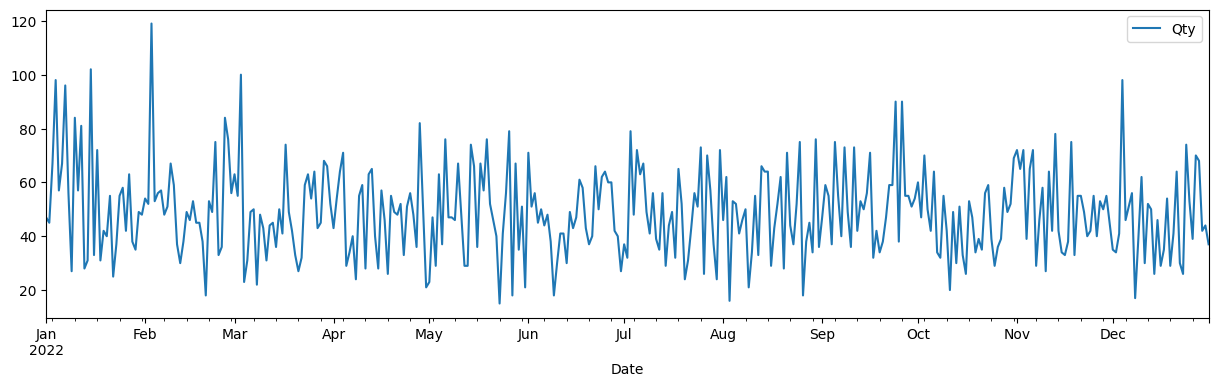

In [32]:
df_agg.set_index('Date').plot(figsize=(15, 4))
plt.show()

Melakukan dekomposisi **(decomposition)** dari time series data yang terdapat dalam DataFrame df_agg untuk memisahkan data menjadi tiga komponen utama: tren **(trend)**, musiman **(seasonal)**, dan sisa **(residual)**.

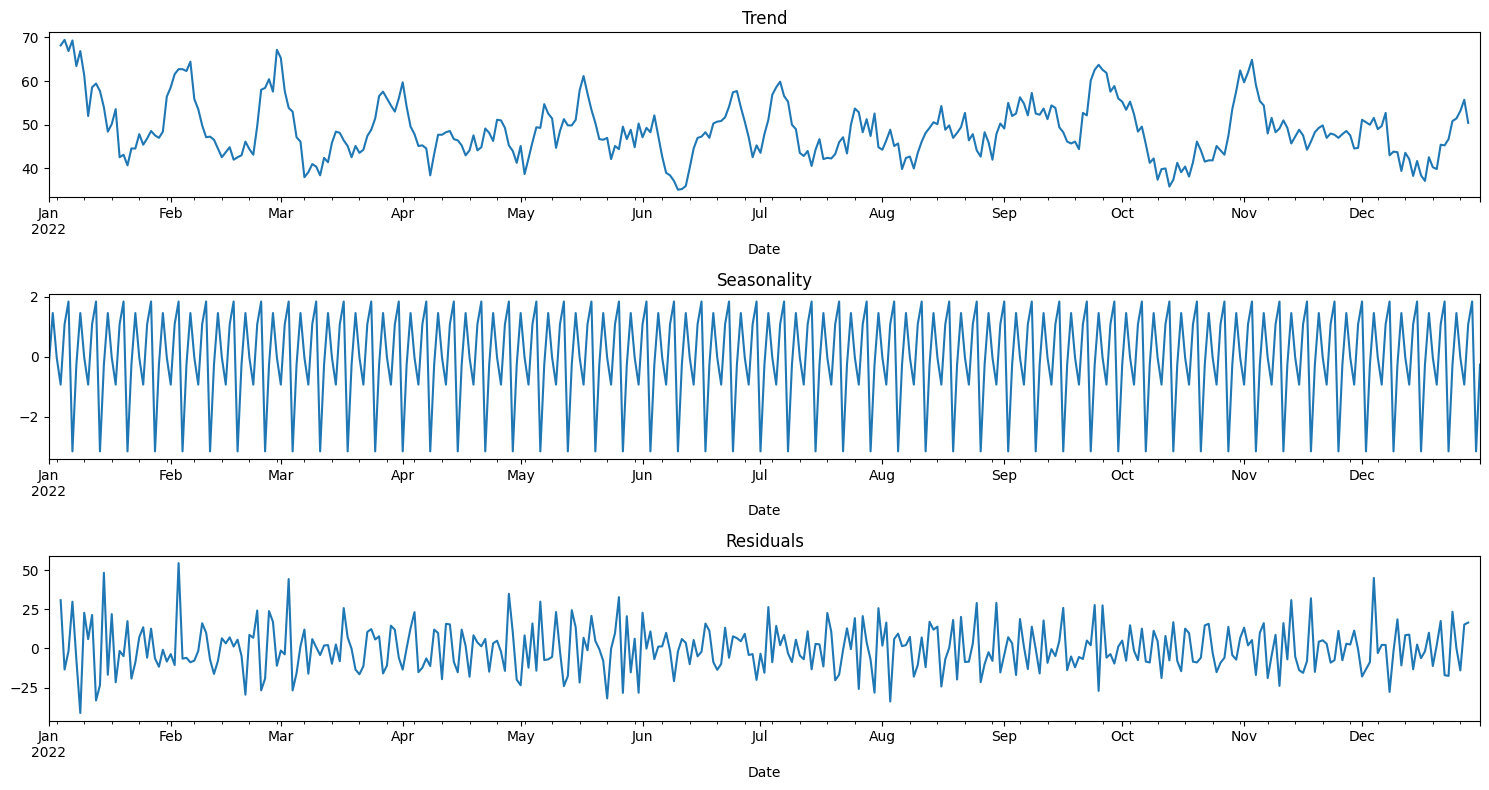

In [33]:
decomposed = seasonal_decompose(df_agg.set_index('Date'))

plt.figure(figsize=(15, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

## Check Stationarity Data

Menguji apakah suatu time series data bersifat **stationary** atau tidak.

In [34]:
# Uji ADF
result_adf = adfuller(df_agg.set_index('Date'))
print("Hasil ADF Test:")
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:", result_adf[4])

# Uji KPSS
result_kpss = kpss(df_agg.set_index('Date'))
print("\nHasil KPSS Test:")
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:", result_kpss[3])

Hasil ADF Test:
ADF Statistic: -19.323189851289346
p-value: 0.0
Critical Values: {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}

Hasil KPSS Test:
KPSS Statistic: 0.2073642420009865
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


*   Hasil ADF Test menunjukkan: **Statistik ADF (ADF Statistic)** sangat negatif (-19.32), yang menunjukkan bahwa data cenderung menjadi **stationary**. Pada umumnya, semakin negatif statistik ADF, semakin kuat bukti bahwa data tersebut stationary.

*   Hasil KPSS Test menunjukkan: **p-value adalah 0.1**, yang lebih besar daripada tingkat signifikansi yang biasanya digunakan **(misalnya 0.05)**. Berarti data dapat dianggap sebagai **stationary** pada tingkat signifikansi 0.1.



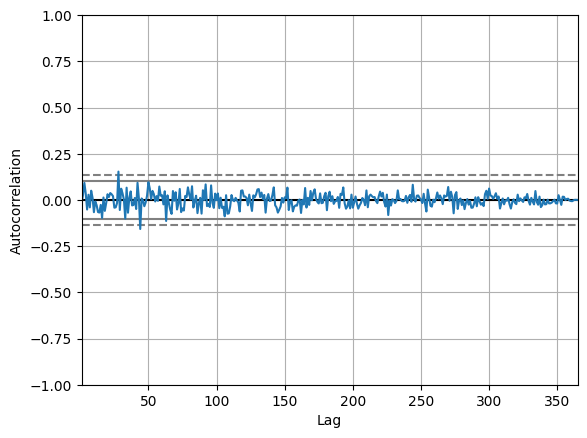

In [35]:
autocorrelation_plot(df_agg['Qty'])
plt.show()

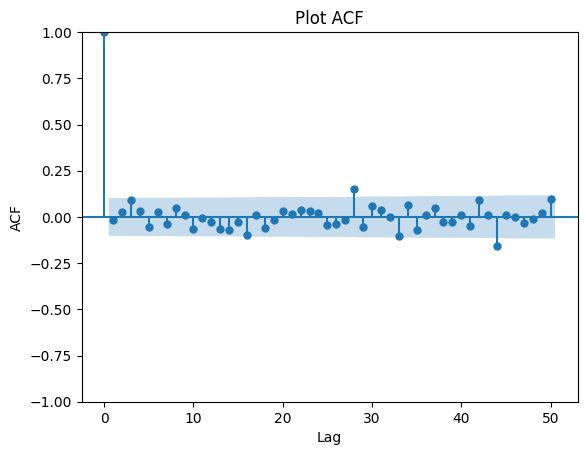

In [36]:
# Plot ACF
plot_acf(df_agg.set_index('Date'), lags=50)
plt.title("Plot ACF")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

Dari hasil Check Stationary Data dapat disimpulkan bahwa data tersebut cenderung **stasioner**

## Train Test Split

Membagi dataset menjadi dua subset yang berbeda: satu untuk pelatihan model **(train set)** dan yang lainnya untuk menguji model **(test set)**.

In [37]:
# Train = 80%
# Test  = 20%

df_train = df_agg[:round(df_agg.shape[0]*0.8)]
df_test = df_agg[round(df_agg.shape[0]*0.8):].reset_index(drop=True)

In [38]:
df_train.tail()

,Date,Qty
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47
291,2022-10-19,34


In [39]:
df_test.head()

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39


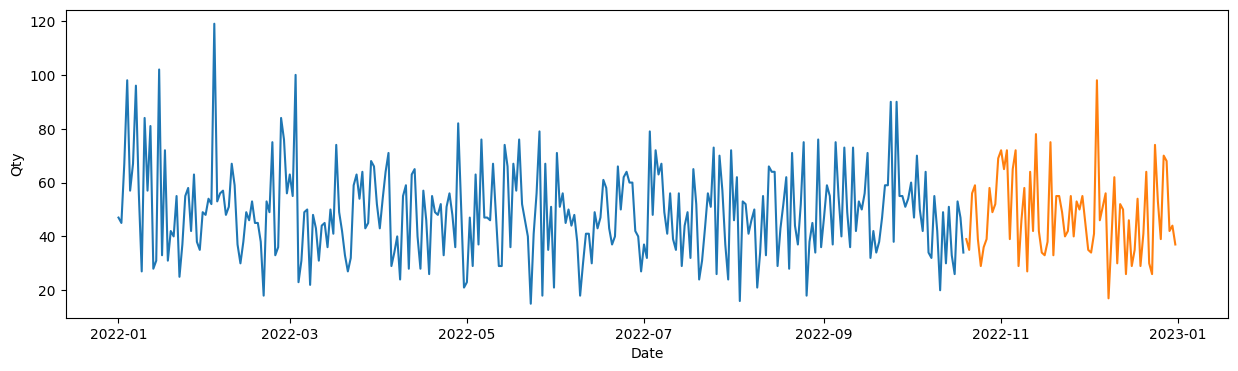

In [40]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])
plt.show()

In [41]:
# Mengatur indeks DataFrame df_train dan df_test ke kolom 'Date'
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

# **Manual Tuning Model Arima**

Proses secara manual mengoptimalkan parameter-parameter yang digunakan dalam model ARIMA untuk mendapatkan hasil yang lebih baik atau performa yang lebih tinggi

In [42]:
# Parameter combinations
pval = [20, 30, 40, 50]
dval = [2]
qval = [1]

results = []

for p in pval:
    for d in dval:
        for q in qval:
            # Define y and model with the current parameter combination
            y = df_train['Qty']
            model = ARIMA(y, order=(p, d, q))
            model = model.fit()

            # Get the forecast
            y_pred = model.get_forecast(len(df_test))

            # Create a DataFrame for predictions
            y_pred_df = y_pred.conf_int()
            y_pred_df['predictions'] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
            y_pred_df.index = df_test.index
            y_pred_out = y_pred_df['predictions']

            # Calculate and store RMSE, MAE, MAPE for the current combination
            rmse_value = np.sqrt(mean_squared_error(df_test['Qty'], y_pred_out))
            mae_value = mean_absolute_error(df_test['Qty'], y_pred_out)
            mape_value = np.mean(np.abs((df_test['Qty'] - y_pred_out) / df_test['Qty'])) * 100

            results.append([p, d, q, rmse_value, mae_value, mape_value])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'rmse', 'mae', 'mape'])
results_df

,p,d,q,rmse,mae,mape
0,20,2,1,17.322291,13.349310,26.764842
1,30,2,1,16.087037,12.952372,29.201395
2,40,2,1,15.567269,12.449805,28.716297
3,50,2,1,16.545926,13.503339,32.627302


Berdasarkan metrik evaluasi yang digunakan **(RMSE, MAE, MAPE)** pilihan parameter **(p=40, d=2, q=1)** memberikan kinerja terbaik


* **RMSE (Root Mean Squared Error):** mengukur sejauh mana perbedaan antara nilai aktual dan nilai yang diprediksi oleh model. Semakin rendah nilai RMSE, semakin baik kinerja model. Dalam kasus ini, model dengan **(p=40, d=2, q=1)** memiliki RMSE terendah sebesar 15.57. Ini menunjukkan bahwa model ini memiliki tingkat kesalahan prediksi yang lebih rendah dibandingkan dengan model lainnya.

* **MAE (Mean Absolute Error):** mengukur kesalahan absolut rata-rata antara nilai aktual dan nilai yang diprediksi. Model dengan **(p=40, d=2, q=1)** juga memiliki MAE terendah, yang menunjukkan bahwa model ini memiliki kesalahan prediksi yang lebih kecil secara keseluruhan.

* **MAPE (Mean Absolute Percentage Error):** mengukur kesalahan dalam bentuk persentase relatif terhadap nilai aktual. Model dengan **(p=40, d=2, q=1)** memiliki MAPE yang lebih rendah dibandingkan dengan model lainnya, yang menunjukkan bahwa model ini memiliki kesalahan relatif yang lebih kecil dalam prediksinya.

In [43]:
# Model dengan parameter (40, 2, 1)
y = df_train['Qty']

model = ARIMA(y, order=(40, 2, 1))
model = model.fit()

y_pred = model.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']

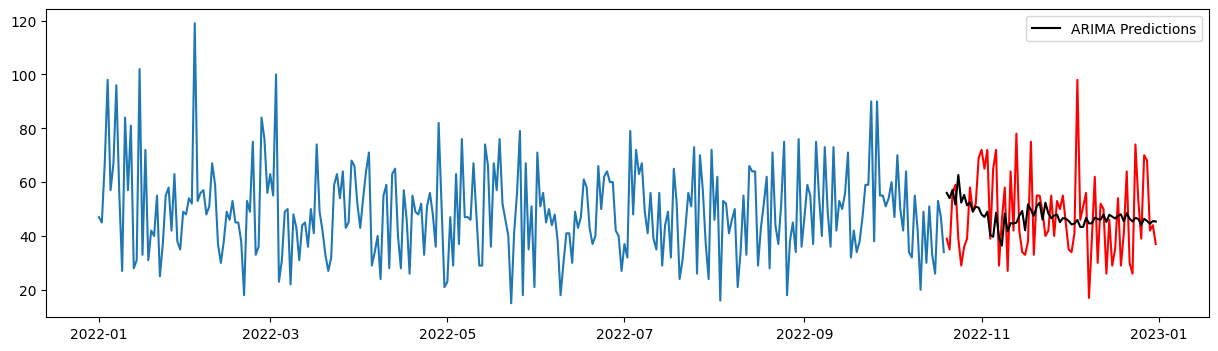

In [44]:
plt.figure(figsize=(15,4))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color = 'red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()
plt.show()

# Forecasting for next 30 days

Mencoba memprediksi jumlah penjualan atau kuantitas produk tertentu selama 30 hari ke depan

In [45]:
# Tanggal terakhir dalam data Anda
last_date = df_merge['Date'].max()

# Buat tanggal untuk 30 hari ke depan
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Buat kerangka data kosong untuk hasil peramalan
forecast_df = pd.DataFrame(index=forecast_dates)

# Loop melalui setiap produk
for product_name in df_merge['Product Name'].unique():
    # Ambil data historis jumlah produk
    product_data = df_merge[df_merge['Product Name'] == product_name]

    # Buat model ARIMA dengan parameter terbaik
    model_product = ARIMA(product_data['Qty'], order=(40, 2, 1))
    model_product = model_product.fit()

    # Lakukan peramalan untuk 30 hari ke depan
    forecast_product = model_product.forecast(steps=30)

    # Tambahkan hasil peramalan ke dalam kerangka data
    forecast_df[f'{product_name}'] = forecast_product.values

# Tampilkan hasil peramalan
forecast_df.head()

,Oat,Ginger Candy,Yoghurt,Coffee Candy,Choco Bar,Crackers,Thai Tea,Cashew,Potato Chip,Cheese Stick
2023-01-01,2.273999,4.648710,4.961165,3.927320,6.727956,4.821645,3.697846,2.745259,1.943788,3.222726
2023-01-02,2.255519,4.728508,4.728252,3.795848,7.814818,3.109795,3.752153,2.454464,2.363307,3.559119
2023-01-03,1.724925,4.024750,3.941868,3.698239,6.006772,3.494582,3.200876,1.947902,1.623241,3.439047
2023-01-04,2.409540,4.902330,4.740076,3.932385,6.166905,3.678511,3.675586,2.129540,2.181180,3.259317
2023-01-05,2.132294,4.907590,5.408844,3.340508,7.826232,4.046688,3.297886,3.629893,2.911375,2.942505


In [46]:
# Ambil rata-rata forecasting untuk setiap produk
mean_forecast = round(forecast_df.mean())
mean_forecast

Oat              2.0
Ginger Candy     5.0
Yoghurt          5.0
Coffee Candy     4.0
Choco Bar        6.0
Crackers         4.0
Thai Tea         4.0
Cashew           3.0
Potato Chip      2.0
Cheese Stick     3.0
dtype: float64

In [86]:
# Total rata-rata untuk setiap produk di bulan depan
total_quantity_per_product = mean_forecast.sum(axis=0)
print(total_quantity_per_product)

38.0


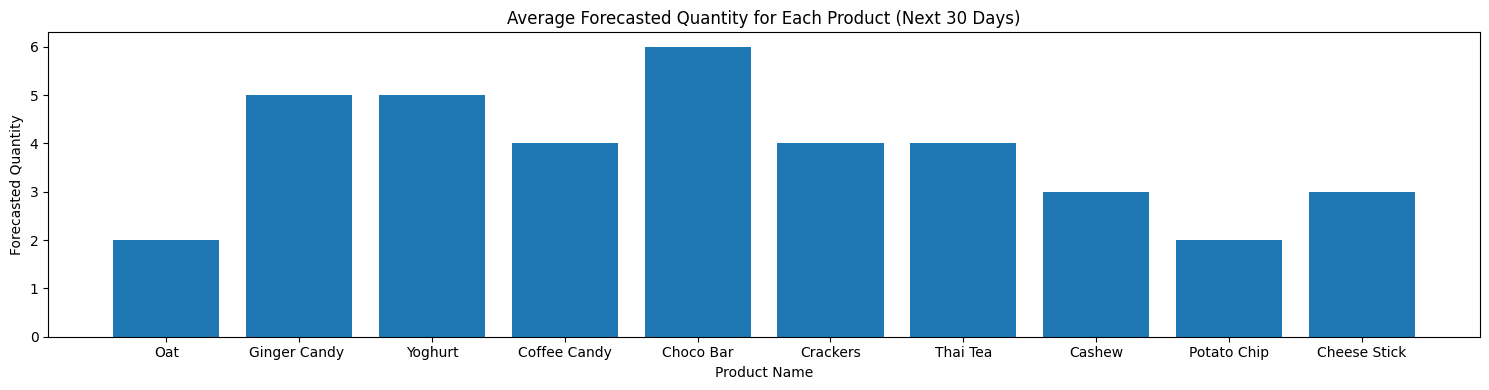

In [47]:
# Plot hasil forecasting
plt.figure(figsize=(15, 4))
plt.bar(mean_forecast.index, mean_forecast.values)
plt.xlabel('Product Name')
plt.ylabel('Forecasted Quantity')
plt.title('Average Forecasted Quantity for Each Product (Next 30 Days)')
plt.tight_layout()
plt.show()

# **Clustering**

Mengelompokkan objek atau data menjadi kelompok-kelompok berdasarkan kesamaan karakteristik atau atribut tertentu.

In [65]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR10008,235,2022-05-21,P8,16000,2,32000,4,37,0,Married,5.35,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
1,TR39070,350,2022-06-23,P8,16000,2,32000,4,38,0,Single,7.95,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
2,TR8584,293,2022-09-14,P8,16000,3,48000,4,54,0,Married,10.40,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR69229,46,2022-05-07,P8,16000,2,32000,4,36,1,Married,8.31,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR88920,447,2022-01-16,P8,16000,1,16000,4,54,1,Married,20.37,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [67]:
df_cluster = df_merge.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}).reset_index()

In [68]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [69]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [73]:
data_cluster_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.13889612e-05, 1.46481819e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.20271286e-05, 1.16804822e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.98656046e-05, 9.20856143e-05, 9.99999995e-01]])

## Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.5215559322569366
For n_clusters = 3 The average silhouette_score is : 0.4512782628208685
For n_clusters = 4 The average silhouette_score is : 0.4571296597676697
For n_clusters = 5 The average silhouette_score is : 0.41467433964189043
For n_clusters = 6 The average silhouette_score is : 0.398563459340275


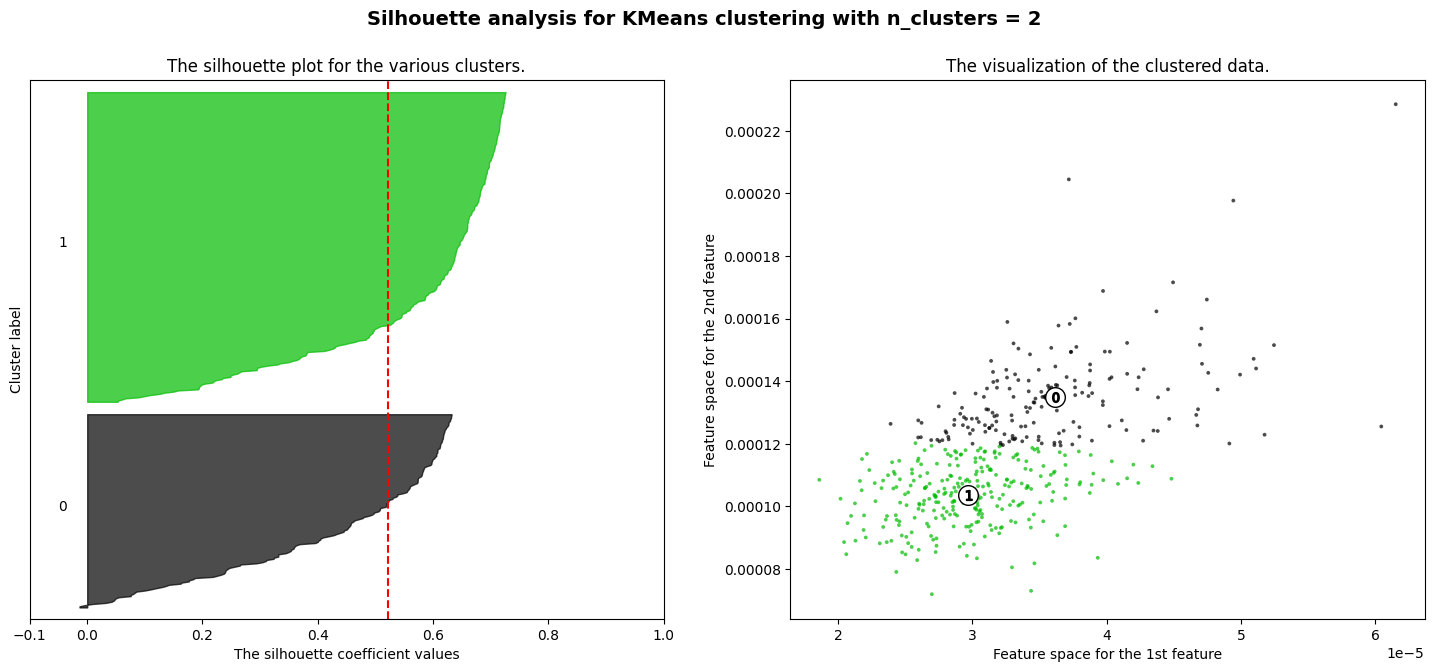

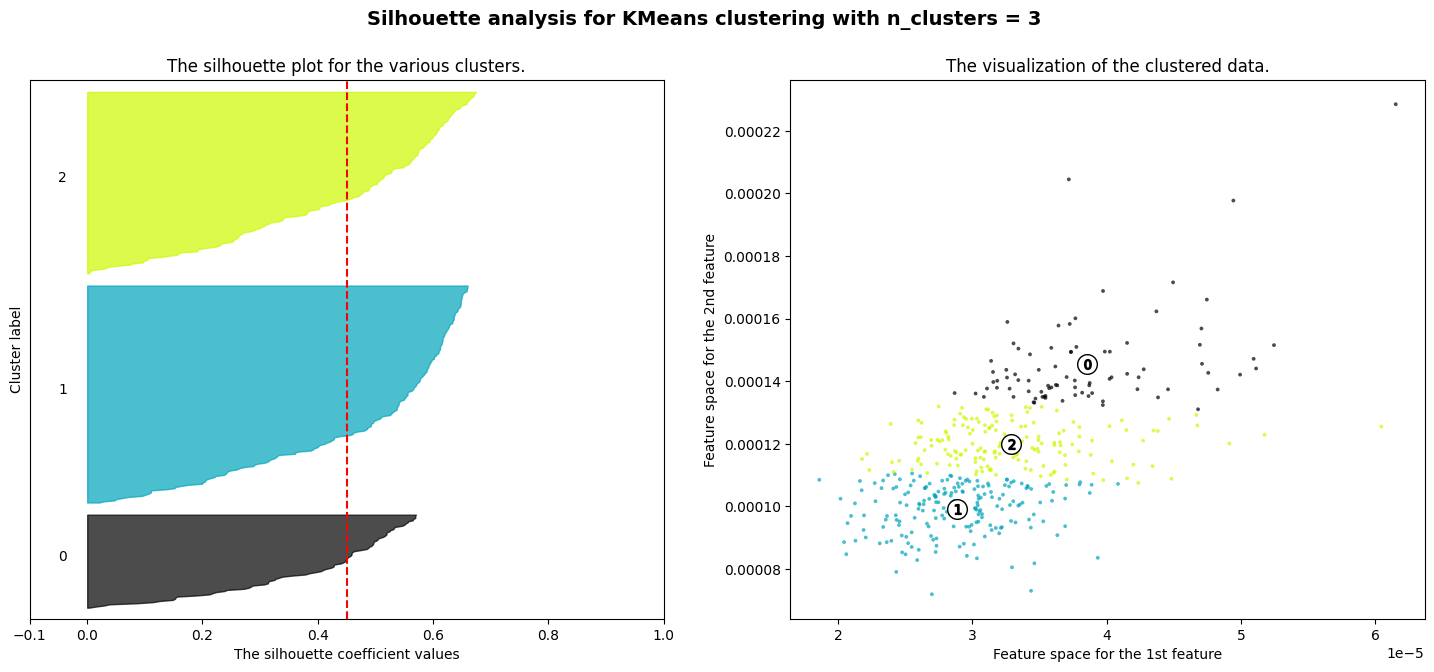

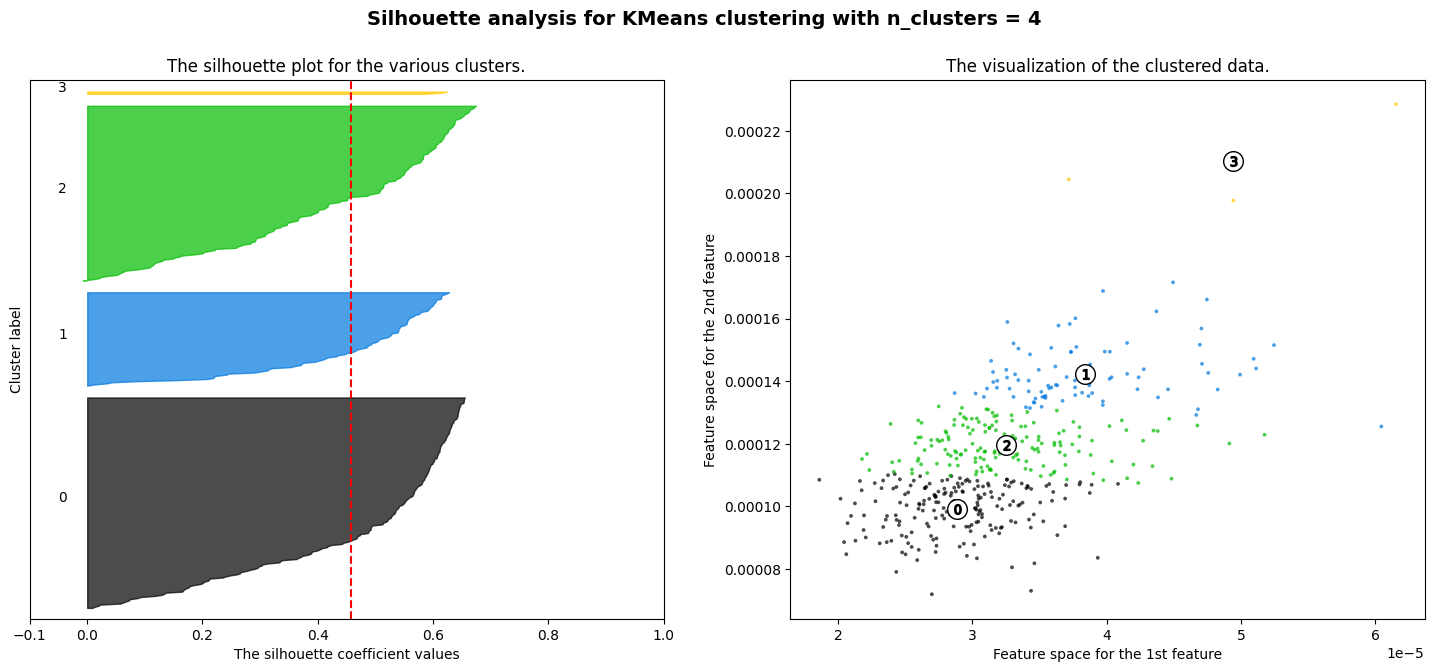

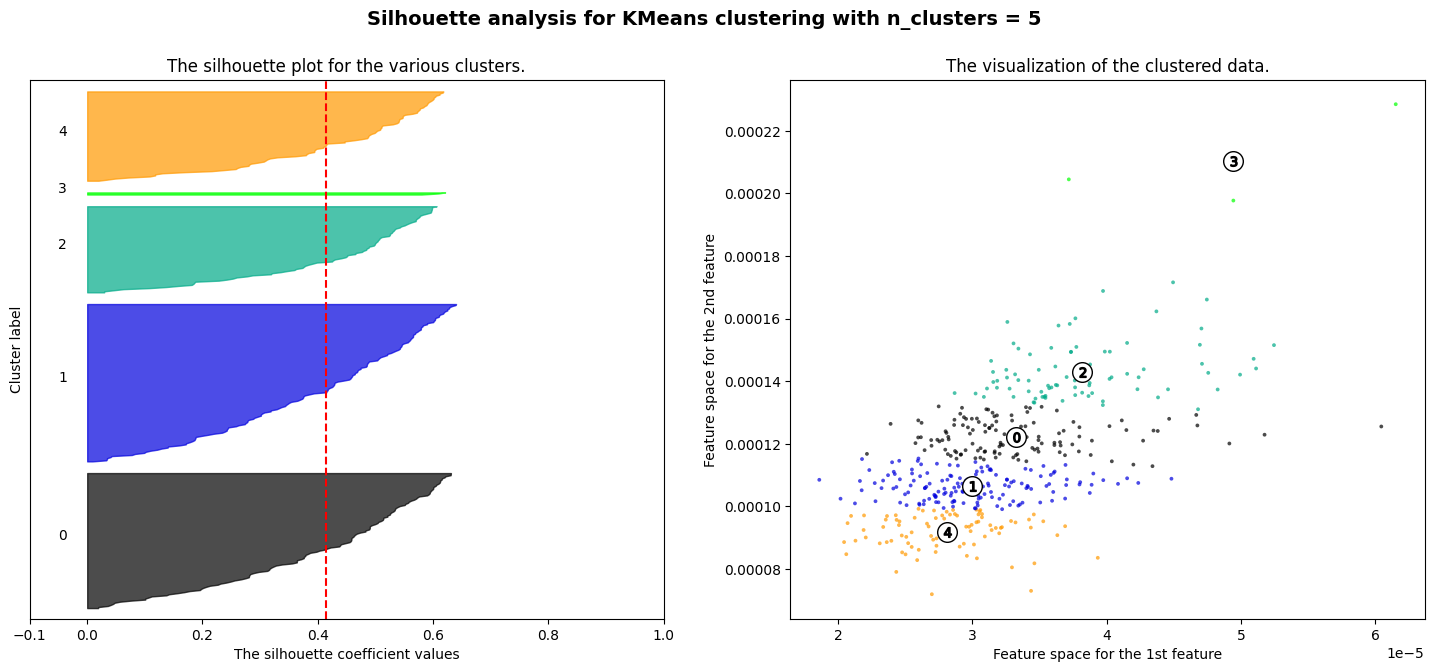

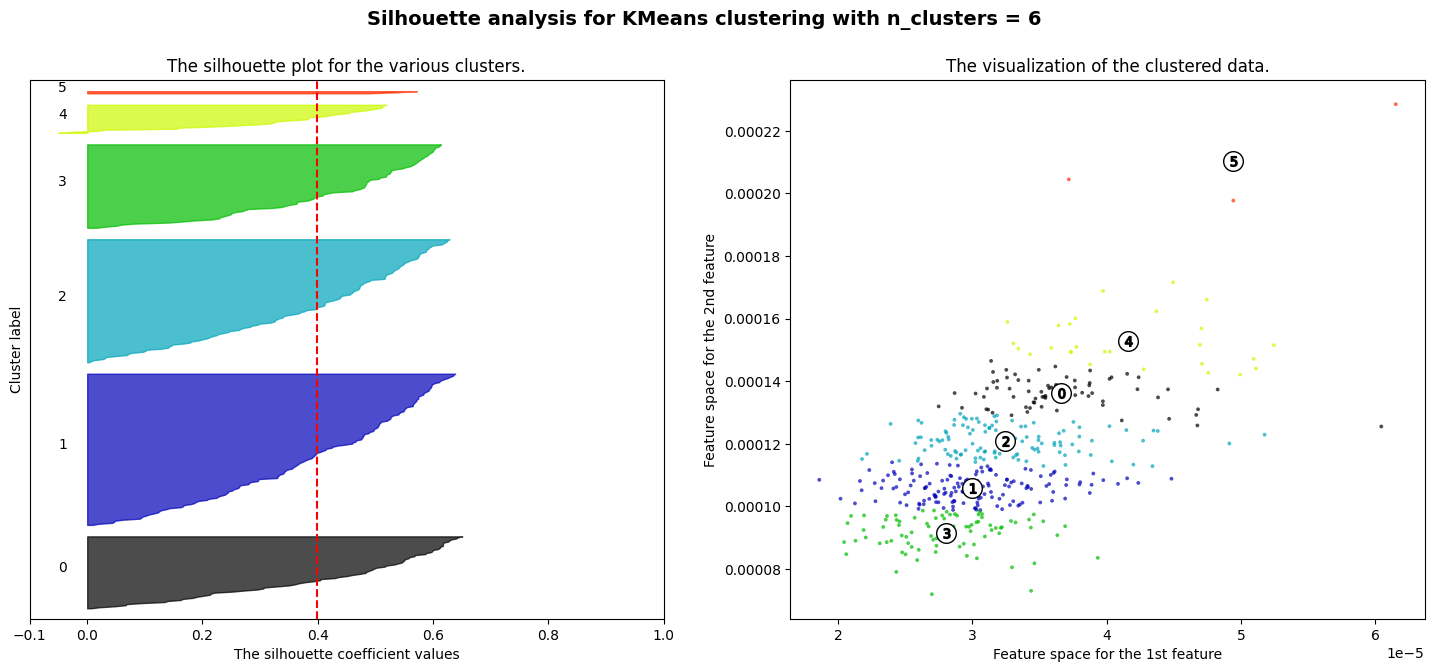

In [80]:
X = data_cluster_normalize

# Range jumlah cluster
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Buat subplot dengan 1 baris dan 2 kolom
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Subplot pertama adalah plot Silhouette
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inisialisasi clusterer dengan jumlah cluster
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Silhouette Score untuk setiap sampel
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Nilai Silhouette untuk setiap sampel
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Subplot kedua adalah plot distribusi cluster
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling plot distribusi cluster
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


**Nilai Silhouette Score** tertinggi biasanya menunjukkan jumlah cluster yang lebih baik. Dalam kasus ini, **n_clusters = 2** memiliki Silhouette Score tertinggi, yaitu sekitar 0.522.

## Elbow Method

In [81]:
K = range(2, 8)
fits = []
score = []

for k in K:
    Model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)
    fits.append(Model)
    score.append(silhouette_score(data_cluster_normalize, Model.labels_, metric='euclidean'))

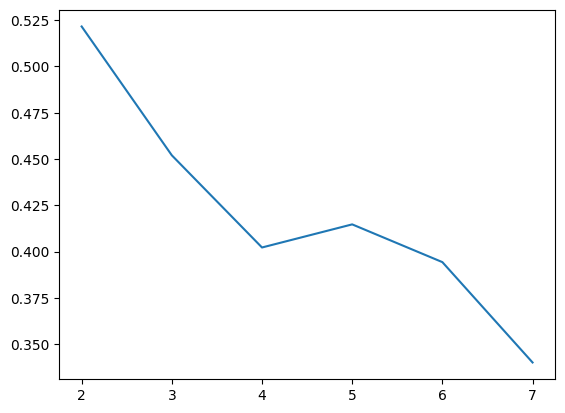

In [82]:
#choose 4 cluster
sns.lineplot(x = K, y = score);

In [83]:
df_cluster['cluster_label'] = fits[2].labels_

In [84]:
df_cluster.groupby('cluster_label').agg({
    'CustomerID': 'count',
    'TransactionID': 'mean',
    'Qty': 'mean',
    'TotalAmount': 'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster_label,,,,
0,126,11.396825,39.079365,409910.317460
1,27,8.703704,33.370370,212385.185185
2,121,10.578512,39.826446,301657.024793
3,173,11.312139,41.693642,371978.612717


## Business Recommendation

1. **Kelompok 0 (Label Cluster 0):**

  Kelompok ini memiliki jumlah pelanggan yang cukup besar dengan rata-rata jumlah transaksi yang tinggi. Rata-rata total pembelian per pelanggan adalah yang tertinggi di antara kelompok.

  *   **Rekomendasi Bisnis:**
  
    Fokus pada promosi produk-produk yang telah dibeli dengan jumlah yang tinggi oleh kelompok ini. Rata-rata total pembelian yang tinggi menunjukkan minat pelanggan terhadap produk tertentu, dan peningkatan promosi produk tersebut dapat meningkatkan penjualan.

  *   **Alasan:**

    Kelompok ini memiliki jumlah pelanggan yang besar dan rata-rata jumlah transaksi yang tinggi, sehingga memiliki potensi besar untuk pertumbuhan pendapatan. Oleh karena itu, peningkatan penjualan produk yang sudah diminati oleh kelompok ini merupakan strategi yang tepat.
  

2. **Kelompok 1 (Label Cluster 1):**

  Kelompok ini memiliki jumlah pelanggan yang lebih kecil dengan rata-rata jumlah transaksi yang sedang. Rata-rata total pembelian per pelanggan lebih rendah dari Kelompok 0.

  *   **Rekomendasi Bisnis:**
  
    Fokus pada peningkatan frekuensi transaksi dalam kelompok ini melalui program loyalitas atau insentif yang dapat mendorong pelanggan untuk berbelanja lebih sering.

  *   **Alasan:**

    Kelompok ini memiliki jumlah pelanggan yang lebih kecil dengan rata-rata jumlah transaksi yang sedang. Peningkatan frekuensi transaksi dapat meningkatkan pendapatan tanpa harus mendapatkan pelanggan baru.

3. **Kelompok 2 (Label Cluster 2):**

  Kelompok ini memiliki jumlah pelanggan yang cukup besar dengan rata-rata jumlah transaksi yang tinggi. Rata-rata total pembelian per pelanggan adalah yang tertinggi kedua setelah Kelompok 0.

  *   **Rekomendasi Bisnis:**
  
    Tingkatkan promosi produk-produk yang telah dibeli dengan jumlah tinggi oleh kelompok ini. Produk-produk ini telah diminati oleh pelanggan dalam kelompok ini.

  *   **Alasan:**

    Kelompok ini memiliki jumlah pelanggan yang cukup besar dengan rata-rata jumlah transaksi yang tinggi, menunjukkan minat yang kuat dalam berbelanja. Peningkatan penjualan produk yang diminati dapat meningkatkan pendapatan.


4. **Kelompok 3 (Label Cluster 3):**

  Kelompok ini memiliki jumlah pelanggan yang besar dengan rata-rata jumlah transaksi dan pembelian yang tinggi.

  *   **Rekomendasi Bisnis:**
  
    Pertahankan tingkat layanan yang tinggi untuk menjaga kesetiaan pelanggan dalam kelompok ini. Analisis cross-selling juga dapat membantu meningkatkan nilai transaksi.

  *   **Alasan:**

    Kelompok ini memiliki jumlah pelanggan yang besar dengan rata-rata jumlah transaksi dan pembelian yang tinggi. Menjaga pelanggan dalam kelompok ini tetap loyal adalah prioritas, dan cross-selling dapat membantu meningkatkan nilai transaksi.